In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [6]:
# human data
df_human = pd.read_csv("data/exp2/human.csv") # good subjects dataframe from R analysis (exp2)
df_human = df_human[['scene', 'frame', 'hr']]
df_human.head()

# df_human = df_human.groupby(['scene', 'frame'])['hr'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,scene,frame,hr
0,1,113,0.733333
1,1,246,0.633333
2,1,326,0.733333
3,1,396,0.466667
4,2,149,0.766667


In [9]:
# model data
# df_model = pd.read_csv("data/exp2/exp2_probes_target_designation_att.csv")
df_model = pd.read_csv("data/exp2/model.csv")
df_model = df_model[['scene', 'frame', 'tracker', 'chain', 'pred_x', 'pred_y', 'pred_x_smoothed', 'pred_y_smoothed', 'importance', 'importance_smoothed']]
df_model.head()

# df_model = df_model.groupby(['scene', 'frame', 'tracker', 'chain']).mean().reset_index()

,scene,frame,tracker,chain,pred_x,pred_y,pred_x_smoothed,pred_y_smoothed,importance,importance_smoothed
0,1,1,1,1,105.375579,226.465590,17.441170,242.026146,0.250000,0.425424
1,1,2,1,1,106.998342,219.438713,14.854209,241.856009,1.000000,0.416278
2,1,3,1,1,100.914917,209.685966,12.200945,241.639451,0.592832,0.406998
3,1,4,1,1,102.708327,215.841192,9.481373,241.373035,0.578455,0.397597
4,1,5,1,1,79.496687,208.467238,6.695777,241.053082,0.914300,0.388083


In [10]:
# probe map
df_probe_map = pd.read_csv("data/exp2/exp2_probe_map_random_eccentricity.csv")
df_probe_map = df_probe_map[["scene", "frame", "tracker"]].rename(columns={'tracker': 'probed_tracker'})
df_probe_map.head()

,scene,frame,probed_tracker
0,1,113,1
1,1,246,3
2,1,326,2
3,1,396,1
4,2,67,1


In [11]:
# merged data
df = pd.merge(df_human, df_model, on=["scene", "frame"], how="inner") # matching model and human dataframes on scenes and frames where probes appear
df = pd.merge(df, df_probe_map, on=["scene", "frame"], how="inner") # matching probe map to merged dataframe
df.head()

,scene,frame,hr,tracker,chain,pred_x,pred_y,pred_x_smoothed,pred_y_smoothed,importance,importance_smoothed,probed_tracker
0,1,113,0.733333,1,1,-76.040289,-156.807210,-88.096156,-130.646934,0.25,0.357800,1
1,1,113,0.733333,2,1,-236.630034,-40.911017,-221.655883,-31.254590,0.25,0.138641,1
2,1,113,0.733333,3,1,149.873378,-143.375375,110.411794,-104.420168,0.25,0.188516,1
3,1,113,0.733333,4,1,-19.355200,-213.755720,10.051536,-193.823693,0.25,0.315043,1
4,1,113,0.733333,1,2,-74.617967,-142.681636,-85.446139,-125.717357,0.25,0.363069,1


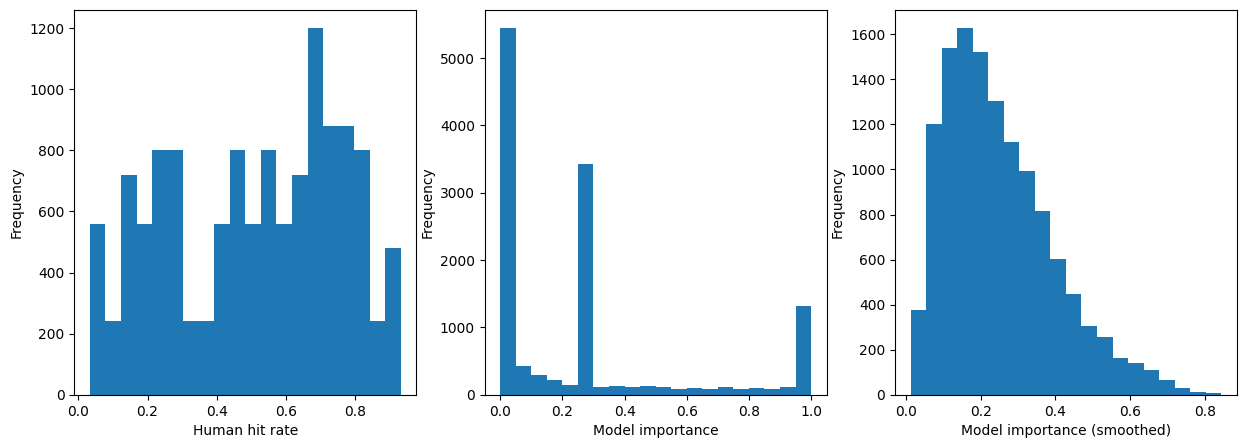

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# histogram of human hit rates
ax[0].hist(df_human["hr"], bins=20)
ax[0].set_xlabel("Human hit rate")
ax[0].set_ylabel("Frequency")

# histogram of model importance
ax[1].hist(df["importance"], bins=20)
ax[1].set_xlabel("Model importance")
ax[1].set_ylabel("Frequency")

# histogram of model importance (smoothed)
ax[2].hist(df["importance_smoothed"], bins=20)
ax[2].set_xlabel("Model importance (smoothed)")
ax[2].set_ylabel("Frequency")

plt.show()

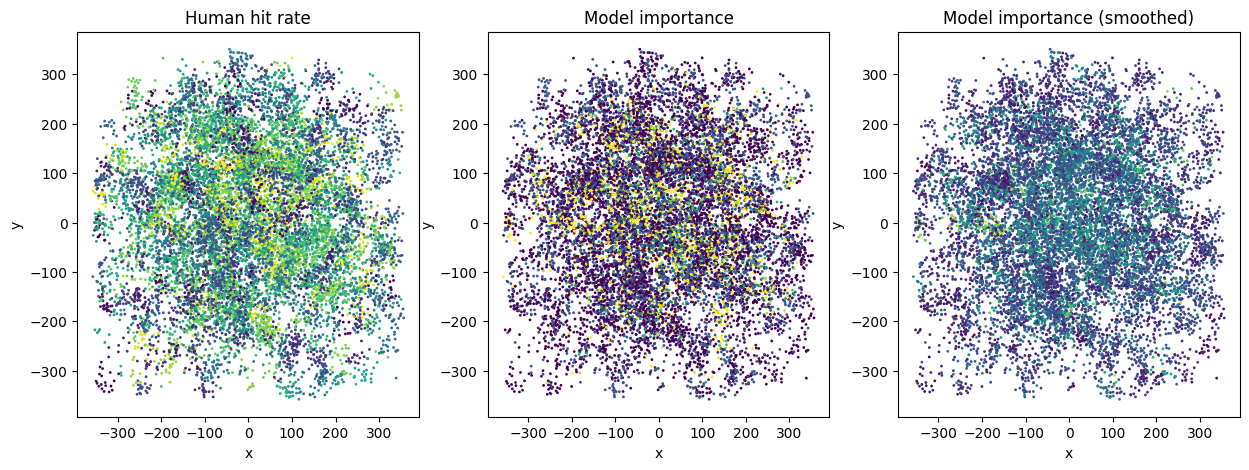

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# scatter plot of human hit rates
ax[0].scatter(df["pred_x"], df["pred_y"], c=df["hr"], alpha=1, s=1)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Human hit rate")

# model importance
ax[1].scatter(df["pred_x"], df["pred_y"], c=df["importance"], alpha=1, s=1)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Model importance")

# model importance (smoothed)
ax[2].scatter(df["pred_x"], df["pred_y"], c=df["importance_smoothed"], alpha=1, s=1)
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Model importance (smoothed)")

plt.show()


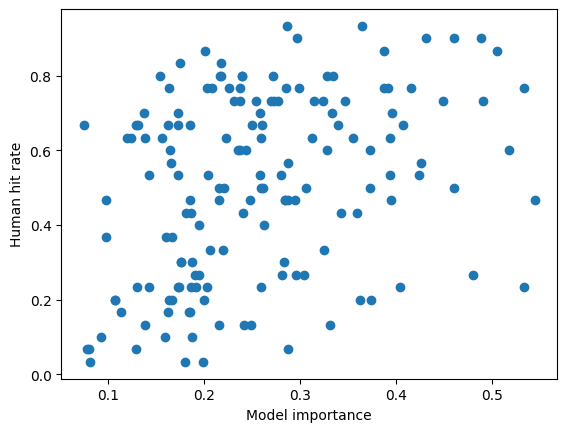

                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     19.80
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           1.63e-05
Time:                        17:52:03   Log-Likelihood:                 7.4652
No. Observations:                 158   AIC:                            -10.93
Df Residuals:                     156   BIC:                            -4.805
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4022      0.030     13.539      0.0

In [21]:
# scatter plot of model importance vs human hit rate
df_hr_imp = df[df["tracker"] == df["probed_tracker"]].groupby(["scene", "frame", "tracker"]).mean().reset_index()
plt.scatter(df_hr_imp["importance_smoothed"], df_hr_imp["hr"], alpha=1)
plt.xlabel("Model importance")
plt.ylabel("Human hit rate")
plt.show()

# fit model
X = df_hr_imp["importance"]
X = sm.add_constant(X)
y = df_hr_imp["hr"]
model = sm.OLS(y, X).fit()
print(model.summary())

In [41]:
# gaussian heatmap from probe locations and importance weights
def get_gaussian_heatmap(df, xmin=-300, xmax=300, ymin=-300, ymax=300,
                         temperature=1.0,
                         sigma=50.0, n=100, normalize=True):
    """Returns a heatmap from probe locations and importance weights.
    
    Args:
        df (pd.DataFrame): dataframe containing probe locations and importance for a single frame
    """
    n_targets = len(np.unique(df["tracker"]))

    locations = np.zeros((n_targets, 2))
    importance = np.zeros(n_targets)

    for i in range(n_targets):
        locations[i, 0] = df[df["tracker"] == i+1]["pred_x_smoothed"].values[0]
        locations[i, 1] = df[df["tracker"] == i+1]["pred_y_smoothed"].values[0]
        importance[i] = df[df["tracker"] == i+1]["importance_smoothed"].values[0]
        # importance[i] = 0.25

    # smooth importance using softmax
    importance = np.exp(importance / temperature)
    importance /= np.sum(importance)

    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n, n))

    for i in range(n_targets):
        Z += importance[i] * np.exp(-((X-locations[i, 0])**2 + (Y-locations[i, 1])**2) / (2*sigma**2))

    if normalize:
        Z /= np.max(Z)

    return Z    




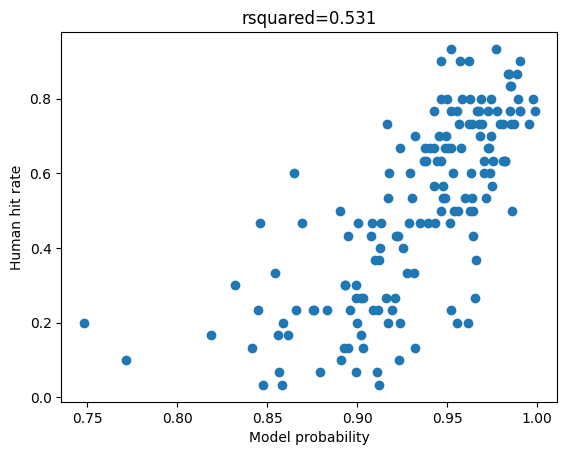

In [50]:
# predict hit rates given the gaussian heatmap
def compute_probability(df, sigma=50.0, temperature=1.0,
                        n=100, xmin=-300, xmax=300, ymin=-300, ymax=300):
    
    heatmap = get_gaussian_heatmap(df, sigma=sigma, temperature=temperature,
                                   n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
    # if np.random.random() < 0.01:
    #     plt.imshow(heatmap, origin="lower")
    #     plt.title("Gaussian heatmap (sigma={}, temperature={})".format(sigma, temperature))
    #     plt.show()

    # plt.imshow(heatmap, origin="lower")
    # plt.show()

    df_probed = df[df["tracker"] == df["probed_tracker"]]
    # evaluate the heatmap at the probed location
    probed_x = df_probed["pred_x"].values
    probed_y = df_probed["pred_y"].values
    x = (probed_x - xmin) / (xmax - xmin) * n
    y = (probed_y - ymin) / (ymax - ymin) * n
    x = np.clip(x, 0, n-1)
    y = np.clip(y, 0, n-1)

    model_probabilities = np.zeros(len(df_probed))
    for i in range(len(df_probed)):
        model_probabilities[i] = heatmap[int(y[i]), int(x[i])]

    return pd.Series({"model_probability": np.mean(model_probabilities)})

sigma = 500
temperature = 1.0

grouped = df.groupby(["scene", "frame"])
hit_rate = grouped["hr"].mean().reset_index()

model_probability = grouped.apply(compute_probability,
                                sigma=sigma,
                                temperature=temperature,
                                ).reset_index()
df_hr_prob = pd.merge(hit_rate, model_probability,
                        on=["scene", "frame"], how="inner")

# remove outliers
# df_hr_prob["hr"] = np.sqrt(df_hr_prob["hr"])
# df_hr_prob["model_probability"] = np.exp(df_hr_prob["model_probability"])

# fit a linear model
X = df_hr_prob["model_probability"]
X = sm.add_constant(X)
y = df_hr_prob["hr"]
model = sm.OLS(y, X).fit()

# plot model predictions
plt.scatter(df_hr_prob["model_probability"], df_hr_prob["hr"])
plt.xlabel("Model probability")
plt.ylabel("Human hit rate")
plt.title("rsquared={:.3f}".format(model.rsquared))
plt.show()



# notes

1. get smoothed model data (85)
2. get proper human data (232)

